# Transformer for Machine Translation

This notebook aims to reproduce transformer model for machine translation from the paper **Attention Is All You Need** using encoder-decoder architecture.
The weights are used from HuggingFace hub and the goal is to have a dive into the model to show transformer fundamentals.

### Sources

* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
* [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)


### Setup

In [1]:
import re

import torch
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from matplotlib import pyplot as plt

c:\Users\kzaja\Documents\Research\Github\reconstructing-transformer\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set()

Make sure dependencies are installed, it is recommended to use GPU for this notebook.

In [3]:
# !pip install sentencepiece -q
# !pip install transformers -q

Use parameters from *Helsinki-NLP* available at [https://huggingface.co/Helsinki-NLP/opus-mt-de-en](https://huggingface.co/Helsinki-NLP/opus-mt-de-en).

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")
transformer = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-de-en")

c:\Users\kzaja\Documents\Research\Github\reconstructing-transformer\.venv\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [5]:
!nvidia-smi

Mon May 29 20:55:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.79       Driver Version: 528.79       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   64C    P0    17W /  50W |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# transformer = transformer.cuda()  # send to GPU
transformer = transformer.eval()

### Tokenization

For machine translation the input is a sentence in source language (denoted `src`), for this model the source language is German. The output should be the same sentence, but translated to English, which is called target language (denoted `tgt`).

In [7]:
text = [
    "Die Maschine ist auf dem Weg nach Hause.",  # source text
]

To allow model to process the text, it needs to be converted into numbers, this process is called tokenization, where each word-piece is assigned a unique number. The tokenization is done using `tokenizers` library, which is a fast Rust library for tokenization. Word-piece is a part of a word, for example, suffix such as *ing* is a unique word piece, since it carries the information about what tense is used (in English). To allow the model to learn to *understand* such texts, it needs to *see* such suffixes as different words.

In [8]:
tokens = tokenizer(text, return_tensors="pt", padding=False)
tokens["input_ids"]

tensor([[  55, 7618,   29,   37,   57,  995,   96, 2427,    3,    0]])

`tokenizer` has unique index for both languages, German and English. Vocabulary size, which is the number of unique tokens known to the model is 58101.

In [9]:
for example in [".", "?", "Die", "ist", "Hause", "", "home", "is", "machine", "translating"]:
    example_tokens = tokenizer([example], return_tensors="pt", padding=False)["input_ids"]
    print(f"Word-piece: '{example}' -> token ids: {example_tokens}")

Word-piece: '.' -> token ids: tensor([[17,  3,  0]])
Word-piece: '?' -> token ids: tensor([[17, 31,  0]])
Word-piece: 'Die' -> token ids: tensor([[55,  0]])
Word-piece: 'ist' -> token ids: tensor([[29,  0]])
Word-piece: 'Hause' -> token ids: tensor([[2427,    0]])
Word-piece: '' -> token ids: tensor([[0]])
Word-piece: 'home' -> token ids: tensor([[   17, 12550,     0]])
Word-piece: 'is' -> token ids: tensor([[19,  0]])
Word-piece: 'machine' -> token ids: tensor([[13799,  1027,     0]])
Word-piece: 'translating' -> token ids: tensor([[3388, 6860,   79,    0]])


It can also decode tokens back to text.

In [10]:
for example in [[17, 3, 0], [17], [0], [13799], [3388, 6860, 79]]:
    example_tokens = torch.tensor(example).unsqueeze(0)
    print(f"Token ids: {example_tokens} -> word-piece: {tokenizer.decode(example_tokens[0])}")

Token ids: tensor([[17,  3,  0]]) -> word-piece: .</s>
Token ids: tensor([[17]]) -> word-piece: 
Token ids: tensor([[0]]) -> word-piece: </s>
Token ids: tensor([[13799]]) -> word-piece: ▁mach
Token ids: tensor([[3388, 6860,   79]]) -> word-piece: translating


To read more on tokenizers, following resources might be useful:
* [HuggingFace Tokenizer Summary](https://huggingface.co/docs/transformers/tokenizer_summary)
* [SentencePiece Paper](https://arxiv.org/abs/1808.06226)

# Model

Model consists of 4 elements:
* Embedding - trainable lookup table that maps the numbers to vectors of fixed size, shared between encoder and decoder
* Encoder - stack of N identical transformer encoder layers
* Decoder - stack of N identical transformer decoder layers
* Head - final linear layer with softmax activation function converting dense embeddings to predictions

### Translation

The whole model is trained on translation problem, which means it's goal it to covert German text to English text. The main entrypoint is `generate` method, which calls the model multiple times using autoregressive predictions to generate the translation. 

In [11]:
text = ["Maschinelles Lernen ist großartig"]
tokens = tokenizer(text, return_tensors="pt", padding=False)

outputs = transformer.generate(**tokens, max_new_tokens=100)  # using **tokens is shorthand for passing tokens and attention mask
tokenizer.decode(outputs[0])

'<pad> Machine learning is great</s>'

**Note**: Source code and documentation of `generate` function are implemented by `GeneratorMixin` from HuggingFace, not by the model itself. 

Generation settings are controlled by the config, which by default is read from model files (they can be usually accessed on HuggingFace hub). For this model generation config looks as follows:

```json
{
  "_from_model_config": true,
  "bad_words_ids": [
    [
      58100
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 58100,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 58100,
  "transformers_version": "4.27.0.dev0"
}
```

Fore more details go to following resources:
* [HuggingFace `GeneratorMixin` documentation](https://huggingface.co/docs/transformers/main_classes/text_generation)
* [HuggingFace Text Generation Strategies](https://huggingface.co/docs/transformers/v4.29.1/en/generation_strategies)

This model will run beam search decoding, which can be seen from the `num_beams` parameter, which is not 1.

In [12]:
text = ["Maschinelles Lernen ist großartig"]
tokens = tokenizer(text, return_tensors="pt", padding=False)

with torch.no_grad():
    outputs = transformer.model(
        input_ids=tokens["input_ids"],
        attention_mask=tokens["attention_mask"],
        # value 58100 is the token id from config for decoder_start_token_id
        decoder_input_ids=torch.Tensor([58100]).long().unsqueeze(0),  # type cast to long and add batch dimension
    )

outputs.keys()  # outputs is ordered dict overload class

odict_keys(['last_hidden_state', 'past_key_values', 'encoder_last_hidden_state'])

Last hidden state is decoder prediction, it contains the same number of sequence elements as decoder inputs, but the content is embedding. From this embedding, with the same size as model dimension output word can be predicted by linear layer with softmax activation function, which is the last trained layer of the model. 

In [13]:
outputs["last_hidden_state"].shape

torch.Size([1, 1, 512])

Prediction of the language modelling head is the probability distribution over entire vocabulary. The word with the highest probability is the prediction of the model (in case of greedy decoding).

In [14]:
with torch.no_grad():
    predictions = transformer.lm_head(outputs["last_hidden_state"])
    predictions = torch.nn.functional.softmax(predictions, dim=-1)
    
predictions.shape

torch.Size([1, 1, 58101])

In [15]:
predictions.sum(dim=-1)

tensor([[1.0000]])

Selecting top 10 results and their probabilities can be done using `torch.topk`

In [16]:
response = torch.topk(predictions.squeeze(0).squeeze(0), k=10, dim=-1)
response

torch.return_types.topk(
values=tensor([7.9567e-01, 1.4070e-02, 1.0553e-02, 6.0083e-03, 3.6412e-03, 3.0484e-03,
        1.0981e-03, 9.8738e-04, 9.6284e-04, 7.3160e-04]),
indices=tensor([ 8853, 33856,  2004, 16984,  6188,  6989,  6232,  6666,  3234, 33590]))

For translating a single word, the outputs are usually not meaningful, since the model needs to see the whole sentence to understand the context. This is the reason, why methods like beam search are used, which allow to generate multiple results and select the best one.

Beam search in transformer mode. lt works by exploring the most likely options down to a certain beam size, which is a hyperparameter that determines the number of paths to explore. The algorithm calculates the score of each option by calculating the probability of a token given everything that comes before it. In the transformer architecture, the output is the entire probability for each word in the vocabulary, for each position in the sequence.

*Note*: Default `topk` value is 50, which means that the model will generate 50 results and select the best one.

In [17]:
for item in response.indices.tolist():
    print(tokenizer.decode(item))

Machine
Mechanical
machine
Learning
Mach
Engineering
Learn
maschine
Maschinen
Machines


Prediction word at further position, requires passing not only source language, but also the previously predicted words. This is called autoregressive generation, since the model generates the output one word at a time using its own predictions. In beam search this step is performed more than once.

In [18]:
text = ["Maschinelles Lernen ist großartig"]
tokens = tokenizer(text, return_tensors="pt", padding=False)
simulated_decoder_predictions = tokenizer("<pad> Machine learning is <pad>", return_tensors="pt", padding=False)


To perform translation, model needs multiple attention masks, which are used to mask out the padding tokens. This is done to prevent the model from paying attention to the padding tokens, which are not part of the input sequence.

In [19]:
generation_inputs = transformer.prepare_inputs_for_generation(decoder_input_ids=simulated_decoder_predictions["input_ids"])
generation_inputs.keys()

dict_keys(['input_ids', 'encoder_outputs', 'past_key_values', 'decoder_input_ids', 'attention_mask', 'head_mask', 'decoder_head_mask', 'cross_attn_head_mask', 'use_cache'])

Masking is done using `torch.triu` function, which returns the upper triangular part of a matrix (2D tensor). The upper triangular part of the matrix is used, since the model is autoregressive, which means that it can only see the previous words, not the future ones. 

Passing very large negative values to the softmax function will result in very small values, which will be rounded to 0. This is used to mask out the padding tokens, since the model will not pay attention to them.

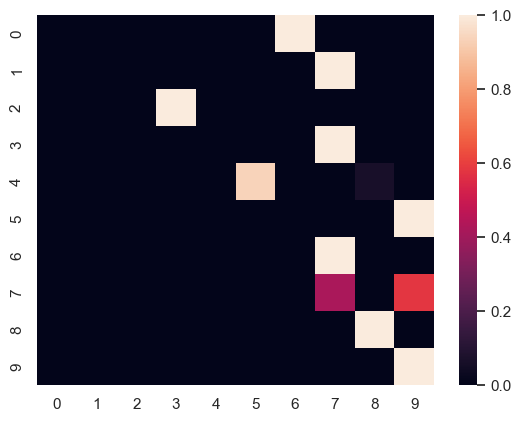

In [20]:
attn = 10 * torch.rand(10, 10)
mask = torch.triu(attn)

output = torch.nn.functional.softmax(mask * attn, dim=-1)
_ = sns.heatmap(output.numpy())

### Embedding

In [21]:
transformer.model.shared

Embedding(58101, 512, padding_idx=58100)

Output shape is `(batch_size, sequence_length, hidden_size)`, where `hidden_size` is the size of the embedding vector, 512 for this model. Each embedding represents a point in high-dimensional space, where similar words are closer to each other. Embeddings are trained during the training process.

In [22]:
with torch.no_grad():
    embedding = transformer.model.shared(tokenizer("Hello world!", return_tensors="pt", padding=False)["input_ids"])

embedding.shape

torch.Size([1, 6, 512])

# Encoder

Encoder is a stack of TransformerLayers, which are identical. Each layer has 2 sublayers:
* Multi-head self-attention mechanism
* Position-wise fully connected feed-forward network

Encoder blocks are connected to each other, so input to $N$-th block is the output of $(N-1)$-th block.

In [23]:
transformer.model.encoder

MarianEncoder(
  (embed_tokens): Embedding(58101, 512, padding_idx=58100)
  (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
  (layers): ModuleList(
    (0-5): 6 x MarianEncoderLayer(
      (self_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (activation_fn): SiLUActivation()
      (fc1): Linear(in_features=512, out_features=2048, bias=True)
      (fc2): Linear(in_features=2048, out_features=512, bias=True)
      (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
)

Positional embedding, which is added to the input embeddings at the bottom of the encoder, is used to provide information about the position of each token in the sequence. This is needed because the model does not contain any recurrent or convolutional layers, so it does not know the order of the tokens.

For this model, the positional embedding is a vector of size 512 (model dimension) and length 512 (max sequence length of the model), which is added to the input embeddings.

In [24]:
tokens = tokenizer("Hello world!", return_tensors="pt", padding=False)["input_ids"]
position_encoding = transformer.model.encoder.embed_positions(input_ids_shape=[100, 512])
position_encoding.shape

torch.Size([512, 512])

Positional encoding is simply added to the embedding, which creates input of encoder block.

In [25]:
inputs = embedding + position_encoding[:embedding.shape[1], :]
inputs.shape

torch.Size([1, 6, 512])

In [26]:
transformer.model.encoder.layers

ModuleList(
  (0-5): 6 x MarianEncoderLayer(
    (self_attn): MarianAttention(
      (k_proj): Linear(in_features=512, out_features=512, bias=True)
      (v_proj): Linear(in_features=512, out_features=512, bias=True)
      (q_proj): Linear(in_features=512, out_features=512, bias=True)
      (out_proj): Linear(in_features=512, out_features=512, bias=True)
    )
    (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (activation_fn): SiLUActivation()
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
    (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
)

This class uses iterable `torch.ModuleList`, so to pass the inputs through all encoder blocks, it is enough to iterate over the list.

In [27]:
with torch.no_grad():
    for layer in transformer.model.encoder.layers:
        # attention mask in encoder is used to prevent attending to padding tokens
        encoder_outputs = layer(inputs, attention_mask=None, layer_head_mask=None)

encoder_outputs[0].shape

torch.Size([1, 6, 512])

# Encoder Block

Inside each encoder block the same operations are performed, the only difference is the parameters inside trained matrices. The two operations are self-attention and feed-forward network.

### Self-Attention

Self-attention is a mechanism that allows the model to learn the dependencies between words in a sequence. It is called self-attention because the attention mechanism is applied to the sequence itself, instead of comparing it to another sequence.

Key projection is a linear layer with learned parameters computing keys from inputs. Keys are abstract representation of the inputs, which are used to compute the attention scores. The intuition behind the content of keys is that they represent the information, which given input should exposes, depending on the context.

For example in the sentence: *I like machine learning, because it is useful and fun to learn*, during encoding the word *it* refers to *machine learning*, so it should be exposed by key projection.

In [28]:
transformer.model.encoder.layers[0].self_attn.k_proj

Linear(in_features=512, out_features=512, bias=True)

The layer can have bias and it needs to preserve the model dimensionality.

In [29]:
with torch.no_grad():
    keys = transformer.model.encoder.layers[0].self_attn.k_proj(inputs)

keys.shape

torch.Size([1, 6, 512])

Query is another abstract representation used for computing attention scores, which is computed using linear layer with learned parameters. The intuition behind the content of queries is that they represent the information, which given input should pay attention to, depending on the context.

In [30]:
transformer.model.encoder.layers[0].self_attn.q_proj

Linear(in_features=512, out_features=512, bias=True)

Shape of queries is the same as keys.

In [31]:
with torch.no_grad():
    query = transformer.model.encoder.layers[0].self_attn.q_proj(inputs)

query.shape

torch.Size([1, 6, 512])

Values are third abstraction, which represents the information given input vector carries. They are also computed using linear layer with learned parameters.

In [32]:
with torch.no_grad():
    values = transformer.model.encoder.layers[0].self_attn.v_proj(inputs)

values.shape

torch.Size([1, 6, 512])

Attention weights (sometimes called attention scores) represent the strength of relation between each pair of tokens. They are computed by multiplying queries and keys and then normalizing them using softmax function, so the sum of weights for each token is 1.

In [33]:
with torch.no_grad():
    attn_weights = query @ keys.transpose(1, 2)
    attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1)

attn_weights.shape

torch.Size([1, 6, 6])

Finally values are multiplied by attention weights to get the context vector, which is the output of self-attention layer containing information about relation between tokens. This is the reason why transformer is able to learn richer dependencies between elements in the sentence, since each token is connected to each other token and the strength of those connections is learned.

In [34]:
outputs = attn_weights @ values
outputs.shape

torch.Size([1, 6, 512])

### Multi-Head Attention

Self-attention described above computes only single context vector of attention scores, which for real problems is often not enough. Multi-head attention is a mechanism, which uses multiple independent (or learnable) key, query and value matrices to capture different relations between tokens. This is similar to using multiple independent convolutional filters in a single layer in conv net. However, attention needs to preserve the shape of input representation, so before output is generated all different context vectors are concatenated and multiplied by another learned matrix converting the shape back to input shape. This matrix is called output projection matrix (it is also learned!). 

Usually more heads means better modelling abilities, the model used in this example has 8 heads.

In [35]:
transformer.model.encoder.layers[0].self_attn.num_heads

8

In [36]:
transformer.model.encoder.layers[0].self_attn.out_proj

Linear(in_features=512, out_features=512, bias=True)

*Note*: Real transformer uses more efficient batch-matrix multiplication of above operations. Also all heads are stacked into matrices, which makes computing keys and queries more efficient. The key and query dimension is `model_dimension / num_heads`, so for this model it is 64.

### Feedforward Network

This part of the transformer is a simple feedforward network with 2 linear layers and nonlinear activation function. It is applied to each token independently, so it does not change the shape of the input. In most implementations first layer is an up-projection in dimension and second is down-projection. For this model, the hidden dimension is 2048 and the output dimension is 512, which is the model dimension.

In [37]:
transformer.model.encoder.layers[0].fc1

Linear(in_features=512, out_features=2048, bias=True)

In [38]:
transformer.model.encoder.layers[0].fc2

Linear(in_features=2048, out_features=512, bias=True)

The activation in the model is performed between feedforward layers, in this case SiLU is used, but ReLU and GeLU (and other variants of derived from piecewise linear functions) are also used often.

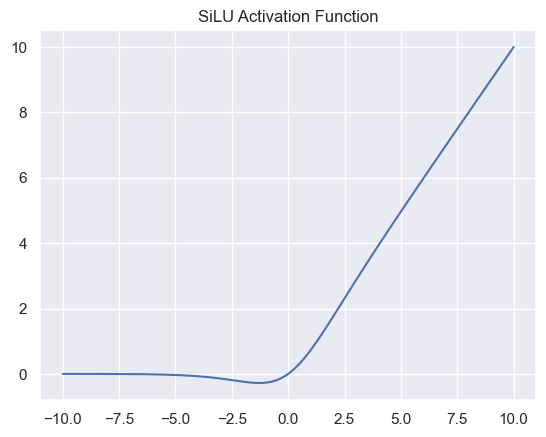

In [39]:
x = torch.linspace(-10, 10, 100)

_ = plt.plot(x.numpy(), transformer.model.encoder.layers[0].activation_fn(x).numpy())
_ = plt.title("SiLU Activation Function")

### Residual Connection

After each layer with trained parameters, residual connection is added, which means that inputs to the layer and added to its outputs, which makes the gradient flow more stable, allowing the model have more layers.

### Normalization and Dropout

Additionally, each layer implements regularization with dropout (removing random portion of features) and normalization (scaling the features to have mean 0 and variance 1). The normalization is called layer normalization, since it is applied to each token independently. For more details see torch documentation about those layers:
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)


# Decoder Block

Decoder block is very similar to encoder block, but it contains one additional attention mechanism. It consists of 3 sublayers:
* Masked multi-head self-attention - the same as in encoder block, but with masking out the future tokens
* Multi-head cross-attention - attention block computing relations between source language and target language tokens
* Feed-forward network - the same as in encoder block 

In [40]:
transformer.model.decoder

MarianDecoder(
  (embed_tokens): Embedding(58101, 512, padding_idx=58100)
  (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
  (layers): ModuleList(
    (0-5): 6 x MarianDecoderLayer(
      (self_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (activation_fn): SiLUActivation()
      (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (encoder_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (encode

Cross-attention is a trainable module with three 4 parameter matrices, which are very similar to self-attention. The only difference is, where the inputs come from. In the decoder cross-attention queries are computed from the previous decoder block, while keys and values are computed from the encoder block. This allows the decoder to pay attention to the source language tokens, while generating the target language tokens.

In [41]:
transformer.model.decoder.layers[0].encoder_attn

MarianAttention(
  (k_proj): Linear(in_features=512, out_features=512, bias=True)
  (v_proj): Linear(in_features=512, out_features=512, bias=True)
  (q_proj): Linear(in_features=512, out_features=512, bias=True)
  (out_proj): Linear(in_features=512, out_features=512, bias=True)
)

# All Together

Transformer is quite complex model, but the fundamental idea of removing recurrence and replacing it with attention allowed the model to achieve spectacular results.

In [42]:
def translate(text, max_new_tokens=100):
    tokens = tokenizer(text, return_tensors="pt", padding=False)
    outputs = transformer.generate(**tokens, max_new_tokens=max_new_tokens)
    predictions = tokenizer.decode(outputs[0])

    return re.sub("<pad>|</s>", "", predictions).strip()  # naive post-processing

In [43]:
translate("Maschinelles Lernen ist großartig")

'Machine learning is great'